In [2]:
%matplotlib inline 
# above line allows for showing plots in a cell easily
import matplotlib # the main plotting library
#matplotlib.style.use('ggplot')
import numpy as np # allows for arrays
import matplotlib.pyplot as plt # getting specific plotting functions
import urllib # URL import functions
import pandas as pd # nice data utilities

In [3]:
q=pd.read_table('./data/log_1.csv', header=0,sep=',',names=['t','tm','s']);

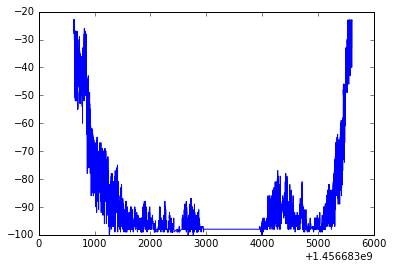

In [4]:
plt.plot(q.t,q.s); 

Below is from https://ocefpaf.github.io/python4oceanographers/blog/2014/05/05/folium/ ...

In [5]:
#fname = './data/DHO.kml'
fname = './data/DHO_cwv_GoogleEarth.kml'

In [6]:
a=open(fname).read();

In [7]:
from xml.dom.minidom import parseString

In [8]:
dom=parseString(a)

In [9]:
latitudes=[]
longitudes=[]


for d in dom.getElementsByTagName('coordinates'):
    coords=d.firstChild.data.split(',')
    longitudes.append(float(coords[0]))
    latitudes.append(float(coords[1]))

In [10]:
timeList=dom.getElementsByTagName('when')
coordList=dom.getElementsByTagName('gx:coord')
placeList=dom.getElementsByTagName('TimeStamp')
#print(timeList[0].toxml())
#print(len(reflist))
print(len(timeList))
print(len(coordList))
print(len(placeList))

821
801
20


I think this means: skip the 'when' items that have 'TimeStamp' associated with them. I.e., the first len(placeList) items. 

In [11]:
times=timeList[(len(placeList)+1):];coords=coordList[:(len(coordList)-1)]

In [12]:
print(times[0].toxml())
print(coords[0].toxml())
print(len(coords)); print(len(times))

<when>2016-02-28T18:22:17.000Z</when>
<gx:coord>-70.976616 43.15733 48.8</gx:coord>
800
800


Yes, this matches the file ... 

In [13]:
t=[]
for ts in times:
    #t.append(ts.firstChild.data.split('.')[0])
    t.append(ts.firstChild.data)

In [14]:
lat=[]
lon=[]
alt=[]
for c in coords:
    thisc = c.firstChild.data.split(' ')
    lat.append(float(thisc[0]))
    lon.append(float(thisc[1]))
    alt.append(float(thisc[2]))

In [15]:
t[222]

'2016-02-28T18:42:21.000Z'

In [16]:
import time
pattern='%Y-%m-%dT%H:%M:%S.000Z'
tGPS=[]
timeShift=18000 #GPS is 5 hours off, which is 18000 seconds
for ts in t:
    thisTime=int(time.mktime(time.strptime(ts, pattern)))-timeShift
    tGPS.append(thisTime)

In [17]:
tGPS[0]

1456683737

In [18]:
tLog=[]
for ts in q.t:
    tLog.append(int(ts))

In [19]:
len(tLog)

6850

In [21]:
# start with some metric

diffBest=(tLog[0])**4

# now go through and compare
diffs=[]
fl=[] # array of indices into tLog for the closest time to any given tGPS time
mins=[]

for i in range(0,len(tGPS)):
    tG=tGPS[i]
    diffs=[]
    for j in range(0,len(tLog)):
        diff=(tLog[j]-tG)**2
        diffs.append(diff)
    myd=np.asarray(diffs);
    mind=min(diffs)
    ta=np.where(myd == myd.min())
    mins.append(mind)
    fl.append(ta[0][0])

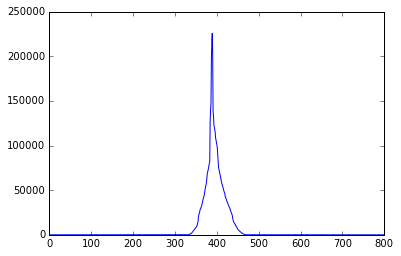

In [22]:
plt.plot(mins)

Interpretation: when the minimum difference in time is much greater than 0, that means that there was no data logged at that GPS location. So we need to apply a threshold. First, try zero difference.

In [40]:
# start with some metric

diffBest=(tLog[0])**4

# now go through and compare
fl=[] # array of indices into tLog for the closest time to any given tGPS time
mins=[]
finalC=[]

for i in range(0,len(tGPS)):
    tG=tGPS[i]
    la=lat[i]
    lo=lon[i]
    diffs=[]
    # generate differences array
    for j in range(0,len(tLog)):
        diff=(tLog[j]-tG)**2
        diffs.append(diff)
    # find the minimum time difference
    myd=np.asarray(diffs);
    mind=min(diffs)
    # if the minimum time difference == 0, then we had a signal
    if (mind<1):
        logIndex=np.where(myd == myd.min())[0][0] #index into the log file minim time
        finalC.append((tG,la,lo,q.s[logIndex]))
    else:
        finalC.append((tG,la,lo,-1000)) # some really low signal level

# Using Folium ...

http://folium.readthedocs.org/en/latest/quickstart.html#getting-started

http://nbviewer.jupyter.org/github/ocefpaf/folium_notebooks/blob/master/test_heatmap.ipynb

In [43]:
# pip install folium
import folium

a=43.15733
b=-70.976616

map_osm = folium.Map(location=[43.15733,-70.976616],zoom_start=13)

kw = dict(opacity=1.0, weight=4)

for i in range(1,len(finalC)):
    rowBack=finalC[i-1]
    row=finalC[i]
    
    coordBack=(rowBack[2],rowBack[1])
    coord=(row[2],row[1])
    loc=[coordBack,coord]
    
    #signal strength 
    s=row[3]
    c='green'
    if (s<-85):
        c='blue' 
    if (s<-95):
        c='yellow'
    if (s<-200):
        c='red'
    l = folium.PolyLine(locations=loc, color=c, **kw)
     
    map_osm.add_children(l)

map_osm

```
Green: 'strong' 
Blue: 'fair'
Yellow: 'weak'
Red: 'no signal'
```

Notes: 

- even 'weak' signal might be sufficient when protocol involves repeated transmission
- signal may improve if care taken to arrange antenna vertically / less beer is consumed

In [54]:
import csv
open('out.csv', 'wb') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',')
    spamwriter.writerows(finalC)

TypeError: a bytes-like object is required, not 'str'

In [60]:
f = open('out.csv','w')
for row in finalC:
    f.write(str(row[0]))
    f.write(",")
    f.write(str(row[2]))
    f.write(",")
    f.write(str(row[1]))
    f.write(",")
    f.write(str(row[3]))
    f.write("\n")
f.close() # you can omit in most cases as the destructor will call it